In [0]:
!nvidia-smi

Fri May  1 08:55:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Import Packages

In [0]:
import os
import random
import tarfile
from math import sqrt
from PIL import Image
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
import numpy as np

import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset
import torch.nn.functional as F
import torchvision.transforms.functional as FT
import torch.backends.cudnn as cudnn
import torch.optim
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont

%pip install wandb 
import wandb
wandb.login()

import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 1.4MB 3.3MB/s 
     |████████████████████████████████| 460kB 20.2MB/s 
     |████████████████████████████████| 102kB 10.5MB/s 
     |████████████████████████████████| 102kB 10.6MB/s 
     |████████████████████████████████| 112kB 24.0MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
     |████████████████████████████████| 71kB 8.9MB/s 
  Created wheel for watchdog: filename=watchdog-0.10.2-cp36-none-any.whl size=73605 sha256=26f594770eba5b2911fc96cf51bd7c9ba68adecba05ffb919da8a3a2de079369
  Stored in directory: /root/.cache/pip/wheels/bc/ed/6c/028dea90d31b359cd2a7c8b0da4db80e41d24a59614154072e
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=058bf6cd856531fe35b44df5178e5147ea9b87d2219e1f545dd77811099ef9eb
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=e

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Download VOC Dataset

In [0]:
if not os.path.exists('train'):
    !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
    !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
    !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar

    os.mkdir('train')
    os.mkdir('test')

    tar_1 = tarfile.open('VOCtrainval_11-May-2012.tar')
    tar_2 = tarfile.open('VOCtest_06-Nov-2007.tar')
    tar_3 = tarfile.open('VOCtrainval_06-Nov-2007.tar')

    tar_1.extractall(path='train')
    tar_2.extractall(path='test')
    tar_3.extractall(path='train')

    tar_1.close()
    tar_2.close()
    tar_3.close()

--2020-05-01 08:57:28--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  12.7MB/s    in 36s     

2020-05-01 08:58:04 (12.1 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

--2020-05-01 08:58:05--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[==========

## Prepare the dataset


The annotations are in xml format:

```
<annotation>
	<folder>VOC2007</folder>
	<filename>001911.jpg</filename>
	<source>
		<database>The VOC2007 Database</database>
		<annotation>PASCAL VOC2007</annotation>
		<image>flickr</image>
		<flickrid>336479820</flickrid>
	</source>
	<owner>
		<flickrid>Vlad Butsky</flickrid>
		<name>Vlad Butsky</name>
	</owner>
	<size>
		<width>500</width>
		<height>333</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>aeroplane</name>
		<pose>Right</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>254</xmin>
			<ymin>123</ymin>
			<xmax>400</xmax>
			<ymax>213</ymax>
		</bndbox>
	</object>
</annotation>
```

In [0]:
def parse_annotation(annotation_path):
    '''Function to parse the annotations'''
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    boxes = list()
    labels = list()
    difficulties = list()

    for object in root.iter('object'):

        difficult = int(object.find('difficult').text == '1')

        label = object.find('name').text.lower().strip()
        if label not in label_map:
            continue

        # extract the bounding box coordinates
        bounding_box = object.find('bndbox')
        xmin = int(bounding_box.find('xmin').text) - 1
        ymin = int(bounding_box.find('ymin').text) - 1
        xmax = int(bounding_box.find('xmax').text) - 1
        ymax = int(bounding_box.find('ymax').text) - 1

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label_map[label])
        difficulties.append(difficult)

    return {'boxes': boxes, 'labels': labels, 'difficulties': difficulties}

In [0]:
data_path = 'train/VOCdevkit'

############################################################################################################
# Create Label mapping
voc_labels = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
              'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')
label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
label_map['background'] = 0
rev_label_map = {v: k for k, v in label_map.items()}  # Inverse mapping

############################################################################################################
# Train Dataset
train_image_filenames = list()
train_objects = list()

for version in ['VOC2007', 'VOC2012']:
    # get the image IDs
    image_ids = open(os.path.join(data_path, version, 'ImageSets/Main/trainval.txt')).read().splitlines()

    for image_id in image_ids:
        # Parse annotation's XML file
        objects = parse_annotation(os.path.join(data_path, version, 'Annotations', image_id + '.xml'))
        if len(objects) == 0:
            continue

        train_objects.append(objects)
        train_image_filenames.append(os.path.join(data_path, version, 'JPEGImages', image_id + '.jpg'))

# sanity check
assert len(train_objects) == len(train_image_filenames)

############################################################################################################
# Test Dataset
test_image_filenames = list()
test_objects = list()

# get the test image IDs
image_ids = open(os.path.join('test/VOCdevkit/VOC2007/ImageSets/Main/test.txt')).read().splitlines()

for image_id in image_ids:
    # Parse annotation's XML file
    objects = parse_annotation(os.path.join('test/VOCdevkit/VOC2007', 'Annotations', image_id + '.xml'))
    if len(objects) == 0:
        continue

    test_objects.append(objects)
    test_image_filenames.append(os.path.join('test/VOCdevkit/VOC2007', 'JPEGImages', image_id + '.jpg'))

# sanity check
assert len(test_objects) == len(test_image_filenames)

print('Train images: %d' % (len(train_image_filenames)))
print('Test images: %d' % (len(test_image_filenames)))

Train images: 16551
Test images: 4952


In [0]:
print(train_image_filenames[0])
train_objects[0]

train/VOCdevkit/VOC2007/JPEGImages/000005.jpg


{'boxes': [[262, 210, 323, 338],
  [164, 263, 252, 371],
  [4, 243, 66, 373],
  [240, 193, 294, 298],
  [276, 185, 311, 219]],
 'difficulties': [0, 0, 1, 0, 1],
 'labels': [9, 9, 9, 9, 9]}

## Generate the Dataset


### Transforms

In [0]:
def zoom_out(image, boxes, filler):
    """
    Perform a zooming out operation by placing the image in a larger canvas of filler material.
    Helps to learn to detect smaller objects.
    :param image: image, a tensor of dimensions (3, original_h, original_w)
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param filler: RBG values of the filler material, a list like [R, G, B]
    :return: zoomed out image, updated bounding box coordinates
    """
    # Calculate dimensions of proposed expanded (zoomed-out) image
    original_h = image.size(1)
    original_w = image.size(2)
    scale = random.uniform(1, 4)
    new_h = int(scale * original_h)
    new_w = int(scale * original_w)

    # Create a filled background
    # Note - do not use expand() like new_image = filler.unsqueeze(1).unsqueeze(1).expand(3, new_h, new_w)
    # because all expanded values will share the same memory, so changing one pixel will change all
    filler = torch.FloatTensor(filler)  # (3)
    new_image = torch.ones((3, new_h, new_w), dtype=torch.float) * filler.unsqueeze(1).unsqueeze(1)  # (3, new_h, new_w)

    # Place the original image at random coordinates in this new image (origin at top-left of image)
    left = random.randint(0, new_w - original_w)
    right = left + original_w
    top = random.randint(0, new_h - original_h)
    bottom = top + original_h
    new_image[:, top:bottom, left:right] = image

    # Adjust bounding boxes' coordinates accordingly
    # Basically shift the x and y values of the boundary of the boxes 
    # Note that we are not resizing the image. This is scaling
    new_boxes = boxes + torch.FloatTensor([left, top, left, top]).unsqueeze(0)  # (n_objects, 4), n_objects is the no. of objects in this image
    return new_image, new_boxes

def random_crop(image, boxes, labels, difficulties):
    """
    Performs a random crop 
    :param image: image, a tensor of dimensions (3, original_h, original_w)
    :param boxes: bounding boxes in boundary coordinates (x_min, y_min, x_max, y_max), a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :param difficulties: difficulties of detection of these objects, a tensor of dimensions (n_objects)
    :return: cropped image, updated bounding box coordinates, updated labels, updated difficulties
    """
    original_h = image.size(1)
    original_w = image.size(2)

    # Keep choosing a minimum overlap until a successful crop is made
    while True:
        # Randomly draw the value for minimum Jaccard overlap
        min_overlap = random.choice([0., .1, .3, .5, .7, .9, None])  # 'None' refers to no cropping

        # If not cropping
        if min_overlap is None:
            return image, boxes, labels, difficulties

        # Try up to 50 times for this choice of minimum overlap
        for _ in range(50):
            # Crop scale must be in [0.3, 1] 
            scale_h = random.uniform(0.3, 1)
            scale_w = random.uniform(0.3, 1)
            new_h = int(scale_h * original_h)
            new_w = int(scale_w * original_w)

            # Aspect ratio has to be in [0.5, 2]
            aspect_ratio = new_h / new_w
            if not 0.5 < aspect_ratio < 2:
                continue

            # Crop coordinates (origin at top-left of image)
            left = random.randint(0, original_w - new_w)
            right = left + new_w
            top = random.randint(0, original_h - new_h)
            bottom = top + new_h
            crop = torch.FloatTensor([left, top, right, bottom])  # (4)

            # Calculate Jaccard overlap between the crop and the bounding boxes
            overlap = find_jaccard_overlap(crop.unsqueeze(0), boxes).squeeze(0)  # (n_objects), n_objects is the no. of objects in this image

            # If all the bounding boxes have Jaccard index of less than the minimum with the crop, try again
            if overlap.max().item() < min_overlap:
                continue

            # Crop image
            new_image = image[:, top:bottom, left:right]  # (3, new_h, new_w)

            # Find centers of original bounding boxes (original bounding boxes are in boundary coordinates)
            bb_centers = (boxes[:, :2] + boxes[:, 2:]) / 2.  # (n_objects, 2)

            # Find bounding boxes whose centers are in the crop
            # (n_objects), a Torch uInt8/Byte tensor, can be used as a boolean index
            centers_in_crop = (bb_centers[:, 0] > left) * (bb_centers[:, 0] < right) * (bb_centers[:, 1] > top) * (bb_centers[:, 1] < bottom)  

            # If not a single bounding box has its center in the crop, try again
            if not centers_in_crop.any():
                continue

            # Discard bounding boxes that don't meet this criterion
            new_boxes = boxes[centers_in_crop, :]
            new_labels = labels[centers_in_crop]
            new_difficulties = difficulties[centers_in_crop]

            # Calculate bounding boxes' new coordinates in the crop
            # mind that crop is still in the original image coordinates
            new_boxes[:, :2] = torch.max(new_boxes[:, :2], crop[:2])  # crop[:2] is [left, top]
            new_boxes[:, :2] -= crop[:2]
            new_boxes[:, 2:] = torch.min(new_boxes[:, 2:], crop[2:])  # crop[2:] is [right, bottom]
            new_boxes[:, 2:] -= crop[:2]

            return new_image, new_boxes, new_labels, new_difficulties

def flip(image, boxes):
    """
    Flip image horizontally.
    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :return: flipped image, updated bounding box coordinates
    """
    # Flip image
    new_image = FT.hflip(image)

    # Flip boxes
    new_boxes = boxes
    new_boxes[:, 0] = image.width - boxes[:, 0] - 1
    new_boxes[:, 2] = image.width - boxes[:, 2] - 1
    new_boxes = new_boxes[:, [2, 1, 0, 3]]

    return new_image, new_boxes

def resize(image, boxes, dims=(300, 300), return_fractional_coords=True):
    """
    Resize image. For the SSD300, resize to (300, 300).
    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :return: resized image, updated bounding box coordinates (or fractional coordinates, in which case they remain the same)
    """
    # Resize image
    new_image = FT.resize(image, dims)

    # Convert bounding boxes into fractional coordinates 
    # Fractional coordinates reamin the same even after rescaling
    old_dims = torch.FloatTensor([image.width, image.height, image.width, image.height]).unsqueeze(0)
    new_boxes = boxes / old_dims  

    # if we want non fractional coordinates, scale the fractional coordinates by the new image dim
    if not return_fractional_coords:
        new_dims = torch.FloatTensor([dims[1], dims[0], dims[1], dims[0]]).unsqueeze(0)
        new_boxes = new_boxes * new_dims

    return new_image, new_boxes

def photometric_distort(image):
    """
    Distort brightness, contrast, saturation, and hue, each with a 50% chance, in random order.
    :param image: image, a PIL Image
    :return: distorted image
    """
    new_image = image

    distortions = [FT.adjust_brightness,
                   FT.adjust_contrast,
                   FT.adjust_saturation,
                   FT.adjust_hue]

    random.shuffle(distortions)

    for distortion in distortions:
        if random.random() < 0.5:
            if distortion.__name__ is 'adjust_hue':
                adjust_factor = random.uniform(-0.07, 0.07)
            else:
                # 'lower' and 'upper' values of 0.5 and 1.5 for brightness, contrast, and saturation
                adjust_factor = random.uniform(0.5, 1.5)

            # Apply this distortion
            new_image = distortion(new_image, adjust_factor)

    return new_image

def transform(image, boxes, labels, difficulties, split):
    """
    Apply the transformations above.
    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :param difficulties: difficulties of detection of these objects, a tensor of dimensions (n_objects)
    :param split: one of 'TRAIN' or 'TEST'
    :return: transformed image, transformed bounding box coordinates, transformed labels, transformed difficulties
    """
    assert split in {'TRAIN', 'TEST'}

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    new_image = image
    new_boxes = boxes
    new_labels = labels
    new_difficulties = difficulties

    # Skip the following operations for evaluation/testing
    if split == 'TRAIN':
        # A series of photometric distortions in random order, each with 50% chance of occurrence
        new_image = photometric_distort(new_image)

        # Convert PIL image to Torch tensor
        new_image = FT.to_tensor(new_image)

        # Expand image (zoom out) with a 50% chance - helpful for training detection of small objects
        # Fill surrounding space with the mean of ImageNet data
        if random.random() < 0.5:
            new_image, new_boxes = zoom_out(new_image, boxes, filler=mean)

        # Randomly crop image (zoom in)
        new_image, new_boxes, new_labels, new_difficulties = random_crop(new_image, new_boxes, new_labels, new_difficulties)

        # Convert Torch tensor to PIL image
        new_image = FT.to_pil_image(new_image)

        # Flip image with a 50% chance
        if random.random() < 0.5:
            new_image, new_boxes = flip(new_image, new_boxes)

    # Resize image to (300, 300) - this also converts absolute boundary coordinates to their fractional form
    new_image, new_boxes = resize(new_image, new_boxes, dims=(300, 300))

    # Convert PIL image to Torch tensor
    new_image = FT.to_tensor(new_image)

    # Normalize by mean and standard deviation of ImageNet data that our base VGG was trained on
    new_image = FT.normalize(new_image, mean=mean, std=std)

    return new_image, new_boxes, new_labels, new_difficulties


### Jaccard Index

In [0]:
def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: box set 1, a tensor of dimensions (n1, 4)
    :param set_2: box set 2, a tensor of dimensions (n2, 4)
    :return: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

### Dataset

In [0]:
class PascalVOC_dataset(Dataset):

    def __init__(self, image_filenames, objects, split):
    
        self.image_filenames = image_filenames
        self.objects = objects
        self.split = split

        assert self.split in {'TRAIN', 'TEST'}
        assert len(self.image_filenames) == len(self.objects)

    def __getitem__(self, i):
        # Read image
        image = Image.open(self.image_filenames[i], mode='r').convert('RGB')

        # Read objects in this image (bounding boxes, labels, difficulties)
        objects = self.objects[i]
        boxes = torch.FloatTensor(objects['boxes'])  # (n_objects, 4)
        labels = torch.LongTensor(objects['labels'])  # (n_objects)
        difficulties = torch.ByteTensor(objects['difficulties'])  # (n_objects)

        # Apply transformations
        image, boxes, labels, difficulties = transform(image, boxes, labels, difficulties, self.split)

        return image, boxes, labels, difficulties

    def get_image(self, i):
        image = Image.open(self.image_filenames[i], mode='r').convert('RGB')
        return image

    def __len__(self):
        return len(self.image_filenames)

train_dataset = PascalVOC_dataset(train_image_filenames, train_objects, 'TRAIN')
test_dataset = PascalVOC_dataset(test_image_filenames, test_objects, 'TEST')

print('Train Dataset Size: %d' % (len(train_dataset)))
print('Test Dataset Size: %d' % (len(test_dataset)))

Train Dataset Size: 16551
Test Dataset Size: 4952


### Visualize Train Transforms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[ 0.1834,  0.3428,  0.7783,  0.7397],
        [-0.0021,  0.2577,  0.9979,  1.0000]])
tensor([12, 18])
tensor([0, 0], dtype=torch.uint8)
tensor(2.6400) tensor(-2.1179)


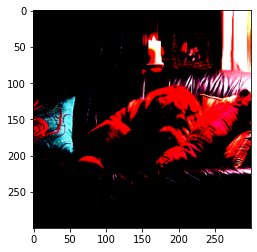

In [0]:
image, boxes, labels, difficulties = train_dataset[67]
plt.imshow(image.numpy().transpose(1,2,0))
print(boxes)
print(labels)
print(difficulties)
print(torch.max(image), torch.min(image))

### Visualize Test Transforms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0.0000, 0.0000, 0.9980, 0.9969]])
tensor([7])
tensor([0], dtype=torch.uint8)
tensor(2.6400) tensor(-2.1179)


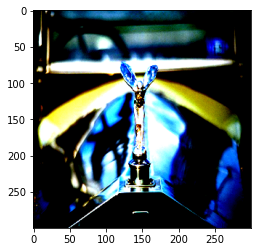

In [0]:
image, boxes, labels, difficulties = test_dataset[random.randint(0, len(test_dataset))]
plt.imshow(image.numpy().transpose(1,2,0))
print(boxes)
print(labels)
print(difficulties)
print(torch.max(image), torch.min(image))

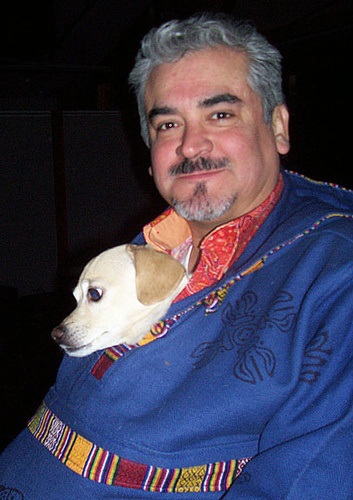

In [0]:
test_dataset.get_image(0)

## Generate Dataloaders

In [0]:
def collate_fn(batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).
        This describes how to combine these tensors of different sizes. We use lists to return boxes, labels and difficulties
        and we combine the image tensors together into a 4D tensor and pass it
        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        boxes = list()
        labels = list()
        difficulties = list()

        for item in batch:
            images.append(item[0])
            boxes.append(item[1])
            labels.append(item[2])
            difficulties.append(item[3])

        # images is a list having torch.Size([3, 300, 300])
        # to convert it to a tensor with a dim for batch
        images = torch.stack(images, dim=0)   # [batch, 3, 300, 300]
        return images, boxes, labels, difficulties  # tensor (N, 3, 300, 300), 3 lists of N tensors each

batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size, shuffle=True, collate_fn= collate_fn, num_workers= 4, pin_memory=True)

images, boxes, labels, difficulties = next(iter(train_loader))
print(images.shape)
print(len(boxes))
print(labels)

torch.Size([32, 3, 300, 300])
32
[tensor([15, 15, 15,  9]), tensor([ 1,  1, 15]), tensor([8]), tensor([15]), tensor([15, 15, 15, 19]), tensor([12, 12]), tensor([ 8, 15]), tensor([ 2,  2,  2, 15, 15]), tensor([ 2, 15]), tensor([7]), tensor([1]), tensor([15, 13]), tensor([7, 7]), tensor([11,  9,  9,  9,  9]), tensor([18, 18]), tensor([7]), tensor([11, 15]), tensor([8]), tensor([14, 15]), tensor([8]), tensor([9]), tensor([ 9, 11]), tensor([7]), tensor([ 2, 15,  6]), tensor([14]), tensor([7]), tensor([7, 6]), tensor([10, 10, 10, 15]), tensor([7]), tensor([7, 7, 7]), tensor([4, 4, 4]), tensor([7])]


## Network

> ### Base Convolutions



In [0]:
class VGGBase(nn.Module):
    """
    VGG base convolutions to produce lower-level feature maps.
    """
    def __init__(self):
        super(VGGBase, self).__init__()

        # Standard convolutional layers in VGG16
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # stride = 1, by default
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)  # ceiling (not floor) here for even dims

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  # retains size because stride is 1 (and padding)

        # Replacements for FC6 and FC7 in VGG16
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)  # atrous convolution

        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

        self.relu = nn.ReLU()
        self.load_pretrained_layers()

    def forward(self, image):
        """
        Forward propagation.
        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: lower-level feature maps conv4_3 and conv7
        """
        out = self.relu(self.conv1_1(image))  # (N, 64, 300, 300)
        out = self.relu(self.conv1_2(out))  # (N, 64, 300, 300)
        out = self.pool1(out)  # (N, 64, 150, 150)

        out = self.relu(self.conv2_1(out))  # (N, 128, 150, 150)
        out = self.relu(self.conv2_2(out))  # (N, 128, 150, 150)
        out = self.pool2(out)  # (N, 128, 75, 75)

        out = self.relu(self.conv3_1(out))  # (N, 256, 75, 75)
        out = self.relu(self.conv3_2(out))  # (N, 256, 75, 75)
        out = self.relu(self.conv3_3(out))  # (N, 256, 75, 75)
        out = self.pool3(out)  # (N, 256, 38, 38), it would have been 37 if not for ceil_mode = True

        out = self.relu(self.conv4_1(out))  # (N, 512, 38, 38)
        out = self.relu(self.conv4_2(out))  # (N, 512, 38, 38)
        out = self.relu(self.conv4_3(out))  # (N, 512, 38, 38)
        conv4_3_feats = out  # (N, 512, 38, 38)
        out = self.pool4(out)  # (N, 512, 19, 19)

        out = self.relu(self.conv5_1(out))  # (N, 512, 19, 19)
        out = self.relu(self.conv5_2(out))  # (N, 512, 19, 19)
        out = self.relu(self.conv5_3(out))  # (N, 512, 19, 19)
        out = self.pool5(out)  # (N, 512, 19, 19), pool5 does not reduce dimensions

        out = self.relu(self.conv6(out))  # (N, 1024, 19, 19)

        conv7_feats = self.relu(self.conv7(out))  # (N, 1024, 19, 19)

        # Lower-level feature maps
        return conv4_3_feats, conv7_feats

    def load_pretrained_layers(self):
        """
        Load pretrained weights into the base network. It's straightforward for conv1 to conv5.
        However, the original VGG-16 does not contain the conv6 and con7 layers.
        Therefore, we convert fc6 and fc7 into convolutional layers, and subsample by decimation.
        """
        # Current state of base
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())

        # Pretrained VGG base
        pretrained_state_dict = torchvision.models.vgg16(pretrained=True).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        # Transfer conv. parameters from pretrained model to current model
        for i, param in enumerate(param_names[:-4]):  # excluding conv6 and conv7 parameters
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

        # Convert fc6, fc7 to convolutional layers, and subsample (by decimation) to sizes of conv6 and conv7
        ######################## fc6
        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)  # (4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']  # (4096)

        # keep every 4th element along the 0th dim, and 3rd element along the 2nd and 3rd dim
        state_dict['conv6.weight'] = self.decimate(conv_fc6_weight, m=[4, None, 3, 3])  # (1024, 512, 3, 3)  
        state_dict['conv6.bias'] = self.decimate(conv_fc6_bias, m=[4])  # (1024)

        ######################## fc7
        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)  # (4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias']  # (4096)

        # keep every 4th element along the 0th and 1st dim
        state_dict['conv7.weight'] = self.decimate(conv_fc7_weight, m=[4, 4, None, None])  # (1024, 1024, 1, 1)
        state_dict['conv7.bias'] = self.decimate(conv_fc7_bias, m=[4])  # (1024)

        # Note: an FC layer of size (K) operating on a flattened version (C*H*W) of a 2D image of size (C, H, W)
        # is equivalent to a convolutional layer with kernel size (H, W), input channels C, output channels K
        # operating on the 2D image of size (C, H, W) without padding
        self.load_state_dict(state_dict)

    def decimate(self,tensor, m):
        """
        Decimate a tensor by a factor 'm', i.e. downsample by keeping every 'm'th value.
        This is used when we convert FC layers to equivalent Convolutional layers, BUT of a smaller size.
        :param tensor: tensor to be decimated
        :param m: list of decimation factors for each dimension of the tensor; None if not to be decimated along a dimension
        :return: decimated tensor
        """
        assert tensor.dim() == len(m)
        for dim in range(tensor.dim()):
            if m[dim] is not None:
                # for each dim in the input tensor, starting from 0th index to the size of the tensor along that dim, pick evey m[dim]th value
                tensor = tensor.index_select(dim=dim, index=torch.arange(start=0, end=tensor.size(dim), step=m[dim]).long())
        return tensor

> ### Auxiliary Convolutions

In [0]:
class AuxiliaryConvolutions(nn.Module):
    """
    Additional convolutions to produce higher-level feature maps.
    """
    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()

        # Auxiliary convolutions on top of the VGG base
        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0)  # stride = 1, by default
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  # dim. reduction because stride > 1

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # dim. reduction because stride > 1

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  # dim. reduction because padding = 0

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  # dim. reduction because padding = 0

        self.relu = nn.ReLU()

        # Initialize convolutions' parameters
        self.init_conv2d()

    def init_conv2d(self):
        """
        Initialize convolution parameters.
        """
        for child in self.children():
            if isinstance(child, nn.Conv2d):
                nn.init.xavier_uniform_(child.weight)
                nn.init.constant_(child.bias, 0.)

    def forward(self, conv7_feats):
        """
        Forward propagation.
        :param conv7_feats: lower-level conv7 feature map, a tensor of dimensions (N, 1024, 19, 19)
        :return: higher-level feature maps conv8_2, conv9_2, conv10_2, and conv11_2
        """
        out = self.relu(self.conv8_1(conv7_feats))  # (N, 256, 19, 19)
        out = self.relu(self.conv8_2(out))  # (N, 512, 10, 10)
        conv8_2_feats = out  # (N, 512, 10, 10)

        out = self.relu(self.conv9_1(out))  # (N, 128, 10, 10)
        out = self.relu(self.conv9_2(out))  # (N, 256, 5, 5)
        conv9_2_feats = out  # (N, 256, 5, 5)

        out = self.relu(self.conv10_1(out))  # (N, 128, 5, 5)
        out = self.relu(self.conv10_2(out))  # (N, 256, 3, 3)
        conv10_2_feats = out  # (N, 256, 3, 3)

        out = self.relu(self.conv11_1(out))  # (N, 128, 3, 3)
        conv11_2_feats = self.relu(self.conv11_2(out))  # (N, 256, 1, 1)

        # Higher-level feature maps
        return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats

> ### Prediction Convolutions

In [0]:
class PredictionConvolutions(nn.Module):
    """
    Convolutions to predict class scores and bounding boxes using lower and higher-level feature maps.
    The bounding boxes (locations) are predicted as encoded offsets w.r.t each of the 8732 priors.
    The class scores represent the scores of each object class in each of the 8732 bounding boxes located.
    """

    def __init__(self, n_classes):
        super(PredictionConvolutions, self).__init__()

        self.n_classes = n_classes

        # Number of prior-boxes we are considering per position in each feature map
        n_boxes = {'conv4_3': 4,
                   'conv7': 6,
                   'conv8_2': 6,
                   'conv9_2': 6,
                   'conv10_2': 4,
                   'conv11_2': 4}

        # Localization prediction convolutions (predict offsets w.r.t prior-boxes)
        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * 4, kernel_size=3, padding=1)

        # Class prediction convolutions (predict classes in localization boxes)
        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * n_classes, kernel_size=3, padding=1)

        # Initialize convolutions' parameters
        self.init_conv2d()

    def init_conv2d(self):
        """
        Initialize convolution parameters.
        """
        for child in self.children():
            if isinstance(child, nn.Conv2d):
                nn.init.xavier_uniform_(child.weight)
                nn.init.constant_(child.bias, 0.)

    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):
        """
        Forward propagation.
        :param conv4_3_feats: conv4_3 feature map   (N, 512, 38, 38)
        :param conv7_feats: conv7 feature map       (N, 1024, 19, 19)
        :param conv8_2_feats: conv8_2 feature map   (N, 512, 10, 10)
        :param conv9_2_feats: conv9_2 feature map   (N, 256, 5, 5)
        :param conv10_2_feats: conv10_2 feature map (N, 256, 3, 3)
        :param conv11_2_feats: conv11_2 feature map (N, 256, 1, 1)
        :return: 8732 locations and class scores (i.e. w.r.t each prior box) for each image
        """
        batch_size = conv4_3_feats.size(0)

        ##############################################################################################
        # Predict localization boxes' bounds (as offsets w.r.t prior-boxes)
        l_conv4_3 = self.loc_conv4_3(conv4_3_feats)  # (N, 16, 38, 38)
        l_conv4_3 = l_conv4_3.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)  # (N, 5776, 4), 5776 boxes on this feature map

        l_conv7 = self.loc_conv7(conv7_feats)  # (N, 24, 19, 19)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)  # (N, 2166, 4), 2116 boxes on this feature map

        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)  # (N, 24, 10, 10)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)  # (N, 600, 4)

        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)  # (N, 24, 5, 5)
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)  # (N, 150, 4)

        l_conv10_2 = self.loc_conv10_2(conv10_2_feats)  # (N, 16, 3, 3)
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)  # (N, 36, 4)

        l_conv11_2 = self.loc_conv11_2(conv11_2_feats)  # (N, 16, 1, 1)
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)  # (N, 4, 4)

        ##############################################################################################
        # Predict classes in localization boxes
        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)  # (N, 4 * n_classes, 38, 38)
        c_conv4_3 = c_conv4_3.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.n_classes)  # (N, 5776, n_classes), 5776 boxes on this feature map

        c_conv7 = self.cl_conv7(conv7_feats)  # (N, 6 * n_classes, 19, 19)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.n_classes)  # (N, 2166, n_classes), 2116 boxes on this feature map

        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)  # (N, 6 * n_classes, 10, 10)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.n_classes)  # (N, 600, n_classes)

        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)  # (N, 6 * n_classes, 5, 5)
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.n_classes)  # (N, 150, n_classes)

        c_conv10_2 = self.cl_conv10_2(conv10_2_feats)  # (N, 4 * n_classes, 3, 3)
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.n_classes)  # (N, 36, n_classes)

        c_conv11_2 = self.cl_conv11_2(conv11_2_feats)  # (N, 4 * n_classes, 1, 1)
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.n_classes)  # (N, 4, n_classes)

        # A total of 8732 boxes
        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)  # (N, 8732, 4)
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2], dim=1)  # (N, 8732, n_classes)

        return locs, classes_scores

> ### SSD300

In [0]:
class SSD300(nn.Module):
    """
    The SSD300 network - encapsulates the base VGG network, auxiliary, and prediction convolutions.
    """
    def __init__(self, n_classes):
        super(SSD300, self).__init__()
        self.n_classes = n_classes

        self.base_conv = VGGBase()
        self.aux_conv = AuxiliaryConvolutions()
        self.pred_conv = PredictionConvolutions(n_classes)

        # Since lower level features (conv4_3_feats) have considerably larger scales, we take the L2 norm and rescale
        # Rescale factor is initially set at 20, but is learned for each channel during back-prop
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))  # there are 512 channels in conv4_3_feats
        nn.init.constant_(self.rescale_factors, 20)

        # Create Prior boxes
        self.priors_cxcy = self.create_prior_boxes()

    def forward(self, images):
        """
        Forward propagation.
        :param images: images, a tensor of dimensions (N, 3, 300, 300)
        :return: 8732 locations and class scores (i.e. w.r.t each prior box) for each image
        """
        # Run VGG base network convolutions (lower level feature map generators)
        conv4_3_feats, conv7_feats = self.base_conv(images)  # (N, 512, 38, 38), (N, 1024, 19, 19)

        # Rescale conv4_3 after L2 norm
        norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()  # (N, 1, 38, 38)
        conv4_3_feats = (conv4_3_feats / norm) * self.rescale_factors  # (N, 512, 38, 38)

        # Run auxiliary convolutions (higher level feature map generators)
        # (N, 512, 10, 10),  (N, 256, 5, 5), (N, 256, 3, 3), (N, 256, 1, 1)
        conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats = self.aux_conv(conv7_feats) 

        # Run prediction convolutions
        # (N, 8732, 4), (N, 8732, n_classes)
        locs, classes_scores = self.pred_conv(conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats)  

        return locs, classes_scores

    def create_prior_boxes(self):
        """
        Create the 8732 prior boxes for the SSD300
        :return: prior boxes in center-size coordinates, a tensor of dimensions (8732, 4)
        """
        fmap_dims = {'conv4_3': 38,
                     'conv7': 19,
                     'conv8_2': 10,
                     'conv9_2': 5,
                     'conv10_2': 3,
                     'conv11_2': 1}

        obj_scales = {'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8_2': 0.375,
                      'conv9_2': 0.55,
                      'conv10_2': 0.725,
                      'conv11_2': 0.9}

        aspect_ratios = {'conv4_3': [1., 2., 0.5],
                         'conv7': [1., 2., 3., 0.5, .333],
                         'conv8_2': [1., 2., 3., 0.5, .333],
                         'conv9_2': [1., 2., 3., 0.5, .333],
                         'conv10_2': [1., 2., 0.5],
                         'conv11_2': [1., 2., 0.5]}

        feature_maps = list(fmap_dims.keys())

        prior_boxes = []

        # for each feature map
        for k, fmap in enumerate(feature_maps):
            # iterate pixel by pixel through rows
            for i in range(fmap_dims[fmap]):
                # iterate pixel by pixel through columns
                for j in range(fmap_dims[fmap]):
                    # generate the centre coordinates in fractional form
                    # for each pixel point (x,y), the centre coordinates are (x+0.5, y+0.5)
                    # Now, divide by the feature map size to convert into fractional form
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    # for each centre, now we have to create multiple priors
                    for ratio in aspect_ratios[fmap]:
                        # append the priors in a list
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])

                        # For an aspect ratio of 1, use an additional prior whose scale is the geometric mean of the
                        # scale of the current feature map and the scale of the next feature map
                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[feature_maps[k + 1]])
                            # For the last feature map, there is no "next" feature map, so just use a scale of 1
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).to(device)  # (8732, 4)
        prior_boxes.clamp_(0, 1)  # (8732, 4)
        return prior_boxes

    def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        """
        Decipher the 8732 locations and class scores (output of ths SSD300) to detect objects.
        For each class, perform Non-Maximum Suppression (NMS) on boxes that are above a minimum threshold.
        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param min_score: minimum threshold for a box to be considered a match for a certain class
        :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via NMS
        :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
        :return: detections (boxes, labels, and scores), lists of length batch_size
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        predicted_scores = F.softmax(predicted_scores, dim=2)  # (N, 8732, n_classes)

        # Lists to store final predicted boxes, labels, and scores for all images
        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            # Decode object coordinates from the form we regressed predicted boxes to
            decoded_locs = cxcy_to_xy(gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))  # (8732, 4), these are fractional pt. coordinates

            # Lists to store boxes and scores for this image
            image_boxes = list()
            image_labels = list()
            image_scores = list()

            # for each box, find the top class
            max_scores, best_label = predicted_scores[i].max(dim=1)  # (8732)

            # Check for each class
            for c in range(1, self.n_classes):

                # get the scores of a particular class for all the boxes
                class_scores = predicted_scores[i][:, c]  # (8732)

                # byte tensor containing 1 for those boxes which qualified for this class
                score_above_min_score = class_scores > min_score  # torch.uint8 (byte) tensor

                # if no boxes qualified, move on to the next class
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue

                # Keep only those scores and boxes that qualified
                class_scores = class_scores[score_above_min_score]  # (n_qualified)
                class_decoded_locs = decoded_locs[score_above_min_score]  # (n_qualified, 4)

                # Sort predicted boxes and scores by scores
                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_qualified)
                class_decoded_locs = class_decoded_locs[sort_ind]  # (n_qualified, 4)

                # Find the overlap between predicted boxes
                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  # (n_qualified, n_qualified)

                # Non-Maximum Suppression (NMS)

                # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
                # 1 implies suppress, 0 implies don't suppress
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)

                # Consider each box in order of decreasing scores
                for box in range(class_decoded_locs.size(0)):
                    # If this box is already marked for suppression
                    if suppress[box] == 1:
                        continue

                    # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
                    suppress = torch.max(suppress, torch.tensor(overlap[box] > max_overlap).byte())
                    # The max operation retains previously suppressed boxes, like an 'OR' operation

                    # Don't suppress this box, even though it has an overlap of 1 with itself
                    suppress[box] = 0

                # Store only unsuppressed boxes for this class
                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
                image_scores.append(class_scores[1 - suppress])

            # If no object in any class is found, store a placeholder for 'background'
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))

            # Concatenate into single tensors
            image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
            image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
            image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
            n_objects = image_scores.size(0)

            # Keep only the top k objects
            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  # (top_k)
                image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
                image_labels = image_labels[sort_ind][:top_k]  # (top_k)

            # Append to lists that store predicted boxes and scores for all images
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size

## Loss

> #### Helper Functions

In [0]:
def xy_to_cxcy(xy):
    """
    Convert bounding boxes from boundary coordinates (x_min, y_min, x_max, y_max) to center-size coordinates (c_x, c_y, w, h).
    :param xy: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    :return: bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1)  # w, h


def cxcy_to_xy(cxcy):
    """
    Convert bounding boxes from center-size coordinates (c_x, c_y, w, h) to boundary coordinates (x_min, y_min, x_max, y_max).
    :param cxcy: bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    :return: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat([cxcy[:, :2] - (cxcy[:, 2:] / 2),  # x_min, y_min
                      cxcy[:, :2] + (cxcy[:, 2:] / 2)], 1)  # x_max, y_max


def cxcy_to_gcxgcy(cxcy, priors_cxcy):
    """
    Encode bounding boxes (that are in center-size form) w.r.t. the corresponding prior boxes (that are in center-size form).
    For the center coordinates, find the offset with respect to the prior box, and scale by the size of the prior box.
    For the size coordinates, scale by the size of the prior box, and convert to the log-space.
    In the model, we are predicting bounding box coordinates in this encoded form.
    :param cxcy: bounding boxes in center-size coordinates, a tensor of size (n_priors, 4)
    :param priors_cxcy: prior boxes with respect to which the encoding must be performed, a tensor of size (n_priors, 4)
    :return: encoded bounding boxes, a tensor of size (n_priors, 4)
    """

    # The 10 and 5 below are referred to as 'variances' in the original Caffe repo, completely empirical
    # They are for some sort of numerical conditioning, for 'scaling the localization gradient'
    # See https://github.com/weiliu89/caffe/issues/155
    return torch.cat([(cxcy[:, :2] - priors_cxcy[:, :2]) / (priors_cxcy[:, 2:] / 10),  # g_c_x, g_c_y
                      torch.log(cxcy[:, 2:] / priors_cxcy[:, 2:]) * 5], 1)  # g_w, g_h


def gcxgcy_to_cxcy(gcxgcy, priors_cxcy):
    """
    Decode bounding box coordinates predicted by the model, since they are encoded in the form mentioned above.
    They are decoded into center-size coordinates.
    This is the inverse of the function above.
    :param gcxgcy: encoded bounding boxes, i.e. output of the model, a tensor of size (n_priors, 4)
    :param priors_cxcy: prior boxes with respect to which the encoding is defined, a tensor of size (n_priors, 4)
    :return: decoded bounding boxes in center-size form, a tensor of size (n_priors, 4)
    """

    return torch.cat([gcxgcy[:, :2] * priors_cxcy[:, 2:] / 10 + priors_cxcy[:, :2],  # c_x, c_y
                      torch.exp(gcxgcy[:, 2:] / 5) * priors_cxcy[:, 2:]], 1)  # w, h

> ### Multibox Loss

In [0]:
class MultiBoxLoss(nn.Module):
    """
    This is a combination of:
    (1) a localization loss for the predicted locations of the boxes, and
    (2) a confidence loss for the predicted class scores.
    """

    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        """
        Forward propagation.
        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param boxes: true  object bounding boxes in boundary coordinates, a list of N tensors
        :param labels: true object labels, a list of N tensors
        :return: multibox loss (scalar)
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)  # (N, 8732, 4)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)  # (N, 8732)

        # For each image
        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            # find the overlap of each true box with each of the predicted priors
            overlap = find_jaccard_overlap(boxes[i], self.priors_xy)  # (n_objects, 8732)

            # For each prior, find the object that has the maximum overlap
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  # (8732)

            # We don't want a situation where an object is not represented in our positive (non-background) priors -
            # 1. An object might not be the best object for all priors, and is therefore not in object_for_each_prior.
            # 2. All priors with the object may be assigned as background based on the threshold (0.5).

            # To remedy this -
            # for each object, prior that has the maximum overlap 
            _, prior_for_each_object = overlap.max(dim=1)  # (n_objects)

            # Then, assign each object to the corresponding maximum-overlap-prior. (This fixes 1.)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)

            # To ensure these priors qualify, artificially give them an overlap of greater than 0.5. (This fixes 2.)
            overlap_for_each_prior[prior_for_each_object] = 1.

            # Labels for each prior
            label_for_each_prior = labels[i][object_for_each_prior]  # (8732)
            # Set priors whose overlaps with objects are less than the threshold to be background (no object)
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0  # (8732)

            # Store
            true_classes[i] = label_for_each_prior

            # Encode center-size object coordinates into the form we regressed predicted boxes to
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  # (8732, 4)

        # Identify priors that are positive (object/non-background)
        positive_priors = true_classes != 0  # (N, 8732)

        # LOCALIZATION LOSS

        # Localization loss is computed only over positive (non-background) priors
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  # (), scalar

        # Note: indexing with a torch.uint8 (byte) tensor flattens the tensor when indexing is across multiple dimensions (N & 8732)
        # So, if predicted_locs has the shape (N, 8732, 4), predicted_locs[positive_priors] will have (total positives, 4)

        # CONFIDENCE LOSS

        # Confidence loss is computed over positive priors and the most difficult (hardest) negative priors in each image
        # That is, FOR EACH IMAGE,
        # we will take the hardest (neg_pos_ratio * n_positives) negative priors, i.e where there is maximum loss
        # This is called Hard Negative Mining - it concentrates on hardest negatives in each image, and also minimizes pos/neg imbalance

        # Number of positive and hard-negative priors per image
        n_positives = positive_priors.sum(dim=1)  # (N)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)

        # First, find the loss for all priors
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  # (N * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)  # (N, 8732)

        # We already know which priors are positive
        conf_loss_pos = conf_loss_all[positive_priors]  # (sum(n_positives))

        # Next, find which priors are hard-negative
        # To do this, sort ONLY negative priors in each image in order of decreasing loss and take top n_hard_negatives
        conf_loss_neg = conf_loss_all.clone()  # (N, 8732)
        conf_loss_neg[positive_priors] = 0.  # (N, 8732), positive priors are ignored (never in top n_hard_negatives)
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  # (N, 8732), sorted by decreasing hardness
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)  # (N, 8732)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, 8732)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

        # As in the paper, averaged over positive priors only, although computed over both positive and hard-negative priors
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()  # (), scalar

        return conf_loss + self.alpha * loc_loss

## Helper Functions for Training

In [0]:
def train(model, criterion, optimizer):
    loss = []
    model.train()  # training mode enables dropout

    for step, (images, boxes, labels, _) in tqdm(enumerate(train_loader), total = len(train_loader), unit='Steps'):

        # Move to GPU if available
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [box.to(device) for box in boxes]
        labels = [label.to(device) for label in labels]

        # Forward prop.
        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

        loss_step = criterion(predicted_locs, predicted_scores, boxes, labels) 
        loss.append(loss_step.item())

        # Backward prop.
        optimizer.zero_grad()
        loss_step.backward()

        # Clip gradients
        clip_gradient(optimizer, grad_clip)

        # Update model parameters
        optimizer.step()

    del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored
    return np.mean(loss)

In [0]:
def save_checkpoint(epoch, model, optimizer, loss):
    global loss_min

    state_dict = {'epoch': epoch,
                  'model': model,
                  'optimizer': optimizer}

    filename = os.path.join(os.getcwd(), 'object_detection.pth')
    torch.save(state_dict, filename)
    
    # If there is an improvement in loss, save checkpoint
    if loss < loss_min:
        loss_min = loss
        print("Min Multibox Loss: {:.4f}\n".format(loss_min))
        filename = os.path.join(os.getcwd(), 'object_detection_best.pth')
        torch.save(state_dict, filename)

def log_performance(epoch, loss, loss_min, lr_scheduler):
    wandb.log({
        "Epoch": epoch,
        "Loss": loss,
        "Min Loss": loss_min,
        "Learning Rate": lr_scheduler.state_dict()['_last_lr'][0]})
    
def clip_gradient(optimizer, grad_clip):
    if grad_clip is not None:
        for group in optimizer.param_groups:
            for param in group['params']:
                if param.grad is not None:
                    param.grad.data.clamp_(-grad_clip, grad_clip)

## Training Loop

In [0]:
# Model parameters
n_classes = len(label_map)  
lr = 0.001  # learning rate
loss_min = np.inf
lr_decay_factor = 0.8
lr_decay_patience = 3
grad_clip = None
num_epochs = 100

checkpoint = None # 'object_detection_best.pth'  # path to model checkpoint
cudnn.benchmark = True # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

wandb.init(name='Object Detection', entity="arkalim", project="Personal")

# Initialize model or load checkpoint
if checkpoint is None:
    start_epoch = 1
    model = SSD300(n_classes=n_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']

# Move the model and Loss function to GPU if available
model = model.to(device)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=lr_decay_factor, patience=lr_decay_patience)

# Loop
for epoch in range(start_epoch, num_epochs):

    loss_train = train(model, criterion, optimizer)

    # Reduce the learning rate on Plateau
    lr_scheduler.step(loss_train)

    print('\n--------------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}'.format(epoch, loss_train))
    print('--------------------------------------------------------')

    # Save checkpoint
    save_checkpoint(epoch, model, optimizer, loss_train)

    # log the performance to wandb
    log_performance(epoch, loss_train, loss_min, lr_scheduler)

## Detect on test set

In [0]:
def detect_test_image(min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in a test image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    # Color map for bounding boxes of detected objects from https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
    distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4', '#46f0f0', '#f032e6',
                    '#d2f53c', '#fabebe', '#008080', '#000080', '#aa6e28', '#fffac8', '#800000', '#aaffc3', '#808000',
                    '#ffd8b1', '#e6beff', '#808080', '#FFFFFF']
    label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}

    index = random.randint(0, len(test_dataset))
    original_image = test_dataset.get_image(index)
    image, _,_,_ = test_dataset[index]

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, return the original image
    if det_labels == ['background']:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.load_default()

    # Iterate through each box
    for i in range(det_boxes.size(0)):

        # Suppress specific classes, if needed
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Draw Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        # a second rectangle at an offset of 1 pixel to increase line thickness
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[det_labels[i]])  

        # Text
        text_size = font.getsize(det_labels[i].upper())
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4., box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white', font=font)
    del draw
    return annotated_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(os.path.join(os.getcwd(), 'object_detection_best.pth'), map_location=device)

model = checkpoint['model']
model = model.to(device)
model.eval()

annotated_image = detect_test_image(min_score=0.2, max_overlap=0.3, top_k=200)
annotated_image

In [0]:
#@title Detect Objects in custom images
#@markdown Enter the URL of any image.

def detect_custom_image(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in a test image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    # Color map for bounding boxes of detected objects from https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
    distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4', '#46f0f0', '#f032e6',
                    '#d2f53c', '#fabebe', '#008080', '#000080', '#aa6e28', '#fffac8', '#800000', '#aaffc3', '#808000',
                    '#ffd8b1', '#e6beff', '#808080', '#FFFFFF']
    label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}



    # Transform
    resize = transforms.Resize((300, 300))
    to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, return the original image
    if det_labels == ['background']:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.load_default()

    # Iterate through each box
    for i in range(det_boxes.size(0)):

        # Suppress specific classes, if needed
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Draw Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        # a second rectangle at an offset of 1 pixel to increase line thickness
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[det_labels[i]])  

        # Text
        text_size = font.getsize(det_labels[i].upper())
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4., box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white', font=font)
    del draw
    return annotated_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load('object_detection_best.pth', map_location=device)

model = checkpoint['model']
model = model.to(device)
model.eval()

URL = 'https://i.insider.com/5df126b679d7570ad2044f3e?width=1100&format=jpeg&auto=webp' #@param {type:"string"}
Min_Score = 0.1 #@param {type: "number"}
Max_Overlap = 0.3 #@param {type: "number"}

from urllib.request import urlretrieve
urlretrieve(URL,'pic.png')
original_image = Image.open('pic.png', mode='r').convert('RGB')

annotated_image = detect_custom_image(original_image, min_score=Min_Score, max_overlap=Max_Overlap, top_k=200)
annotated_image

## Evaluate mAP

In [0]:
def calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties):
    """
    Calculate the Mean Average Precision (mAP) of detected objects.
    :param det_boxes: list of tensors, one tensor for each image containing detected objects' bounding boxes
    :param det_labels: list of tensors, one tensor for each image containing detected objects' labels
    :param det_scores: list of tensors, one tensor for each image containing detected objects' labels' scores
    :param true_boxes: list of tensors, one tensor for each image containing actual objects' bounding boxes
    :param true_labels: list of tensors, one tensor for each image containing actual objects' labels
    :param true_difficulties: list of tensors, one tensor for each image containing actual objects' difficulty (0 or 1)
    :return: list of average precisions for all classes, mean average precision (mAP)
    """

    assert len(det_boxes) == len(det_labels) == len(det_scores) == len(true_boxes) == len(true_labels) == len(true_difficulties)  
    n_classes = len(label_map)

    ############################################################################################################
    # Processing True Boxes

    # Store all (true) objects in a single continuous tensor while keeping track of the image it is from
    true_images = list()
    for i in range(len(true_labels)):
        true_images.extend([i] * true_labels[i].size(0))
        # true_images will be like [0, 0, 0, 1, 1, 2, 2, 2, 2....] indicating number of objects per image

    true_images = torch.LongTensor(true_images).to(device)  # (n_objects), n_objects is the total no. of objects across all images
    true_boxes = torch.cat(true_boxes, dim=0)  # (n_objects, 4)                # Stacking the tensors in the list 
    true_labels = torch.cat(true_labels, dim=0)  # (n_objects)                 # Stacking the tensors in the list
    true_difficulties = torch.cat(true_difficulties, dim=0)  # (n_objects)     # Stacking the tensors in the list

    assert true_images.size(0) == true_boxes.size(0) == true_labels.size(0) == true_difficulties.size(0)

    ############################################################################################################
    # Processing Predicted Boxes 

    # Store all detections in a single continuous tensor while keeping track of the image it is from
    det_images = list()
    for i in range(len(det_labels)):
        det_images.extend([i] * det_labels[i].size(0))
        # det_images will be like [0, 0, 0, 1, 1, 2, 2, 2, 2....] indicating number of objects per image

    det_images = torch.LongTensor(det_images).to(device)  # (n_detections)
    det_boxes = torch.cat(det_boxes, dim=0)  # (n_detections, 4)
    det_labels = torch.cat(det_labels, dim=0)  # (n_detections)
    det_scores = torch.cat(det_scores, dim=0)  # (n_detections)

    assert det_images.size(0) == det_boxes.size(0) == det_labels.size(0) == det_scores.size(0)

    ############################################################################################################
    # Calculate APs for each class (except background)

    average_precisions = torch.zeros((n_classes - 1), dtype=torch.float)  # (n_classes - 1)
    for c in range(1, n_classes):
        # Extract only objects with this class
        true_class_images = true_images[true_labels == c]  # (n_class_objects)
        true_class_boxes = true_boxes[true_labels == c]  # (n_class_objects, 4)
        true_class_difficulties = true_difficulties[true_labels == c]  # (n_class_objects)

        # No of easy true objects for this class
        n_easy_class_objects = (1 - true_class_difficulties).sum().item()  

        # Keep track of which true objects with this class have already been 'detected'
        # So far, none
        true_class_boxes_detected = torch.zeros((true_class_difficulties.size(0)), dtype=torch.uint8).to(device)  # (n_class_objects)

        # Extract only detections with this class
        det_class_images = det_images[det_labels == c]  # (n_class_detections)
        det_class_boxes = det_boxes[det_labels == c]  # (n_class_detections, 4)
        det_class_scores = det_scores[det_labels == c]  # (n_class_detections)
        n_class_detections = det_class_boxes.size(0)

        # Proceed only if some boxes of this class are detected
        # if no object of the current class is detected, move to the next class
        if n_class_detections == 0:
            continue

        # Sort detections in decreasing order of confidence/scores
        det_class_scores, sort_ind = torch.sort(det_class_scores, dim=0, descending=True)  # (n_class_detections)
        det_class_images = det_class_images[sort_ind]  # (n_class_detections)
        det_class_boxes = det_class_boxes[sort_ind]  # (n_class_detections, 4)

        # In the order of decreasing scores, check if true or false positive
        true_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        false_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)

        # Iterate over all the detected boxes of this class in the decreasing order of scores
        for d in range(n_class_detections):
            this_detection_box = det_class_boxes[d].unsqueeze(0)  # (1, 4)
            this_image = det_class_images[d]  # (), scalar

            # Find objects in this image of this class, their difficulties, and whether they have been detected before
            object_boxes = true_class_boxes[true_class_images == this_image]  # (n_class_objects_in_img)
            object_difficulties = true_class_difficulties[true_class_images == this_image]  # (n_class_objects_in_img)

            # If no such true object in this image, then the detection is a false positive
            # Move to the next detection
            if object_boxes.size(0) == 0:
                false_positives[d] = 1
                continue

            # Proceed only if there is some true object of this class present in this image
            # Find maximum overlap of this detection with objects in this image of this class
            overlaps = find_jaccard_overlap(this_detection_box, object_boxes)  # (1, n_class_objects_in_img)
            max_overlap, ind = torch.max(overlaps.squeeze(0), dim=0)  # (), scalars

            # 'ind' is the index of the object in these image-level tensors 'object_boxes', 'object_difficulties'
            # In the original class-level tensors 'true_class_boxes', etc., 'ind' corresponds to object with index...
            original_ind = torch.LongTensor(range(true_class_boxes.size(0)))[true_class_images == this_image][ind]
            # We need 'original_ind' to update 'true_class_boxes_detected'

            # If the maximum overlap is greater than the threshold of 0.5, it's a match
            if max_overlap.item() > 0.5:
                # If the object it matched with is 'difficult', ignore it
                if object_difficulties[ind] == 0:
                    # If this true object has already not been detected, it's a true positive
                    if true_class_boxes_detected[original_ind] == 0:
                        true_positives[d] = 1
                        true_class_boxes_detected[original_ind] = 1  # this object has now been detected/accounted for
                    # Otherwise, it's a false positive (since this object is already accounted for)
                    else:
                        false_positives[d] = 1
            # Otherwise, the localization error is large (false positive)
            else:
                false_positives[d] = 1

        # After labelling each predicted box as either TP or FP for this class
        # Compute cumulative precision and recall at each detection for this class in the order of decreasing scores
        cumul_true_positives = torch.cumsum(true_positives, dim=0)  # (n_class_detections)
        cumul_false_positives = torch.cumsum(false_positives, dim=0)  # (n_class_detections)
        cumul_precision = cumul_true_positives / (cumul_true_positives + cumul_false_positives + 1e-10)  # (n_class_detections)
        cumul_recall = cumul_true_positives / n_easy_class_objects  # (n_class_detections)

        # Find the mean of the maximum of the precisions corresponding to recalls above the threshold 't'
        # Follow 11-point interpolation scheme for mAP
        recall_thresholds = torch.arange(start=0, end=1.1, step=.1).tolist()  # (11)
        precisions = torch.zeros((len(recall_thresholds)), dtype=torch.float).to(device)  # (11)

        for i, t in enumerate(recall_thresholds):
            recalls_above_t = cumul_recall >= t
            if recalls_above_t.any():
                precisions[i] = cumul_precision[recalls_above_t].max()
            else:
                precisions[i] = 0.
        average_precisions[c - 1] = precisions.mean()  # c is in [1, n_classes - 1]

    # Calculate Mean Average Precision (mAP)
    mean_average_precision = average_precisions.mean().item()

    # Keep class-wise average precisions in a dictionary
    average_precisions = {rev_label_map[c + 1]: v for c, v in enumerate(average_precisions.tolist())}

    return average_precisions, mean_average_precision


def evaluate(eval_loader, model):
    """
    Evaluate.
    :param test_loader: DataLoader for test data
    :param model: model
    """

    # Make sure it's in eval mode
    model.eval()

    # Lists to store detected and true boxes, labels, scores
    det_boxes = list()
    det_labels = list()
    det_scores = list()
    true_boxes = list()
    true_labels = list()
    true_difficulties = list()  # it is necessary to know which objects are 'difficult', see 'calculate_mAP' in utils.py

    with torch.no_grad():
        # Batches
        for i, (images, boxes, labels, difficulties) in enumerate(tqdm(eval_loader, desc='Evaluating')):
            images = images.to(device)  # (N, 3, 300, 300)

            # Forward prop.
            predicted_locs, predicted_scores = model(images)

            # Detect objects in SSD output
            # Evaluation MUST be at min_score=0.01, max_overlap=0.45, top_k=200 for fair comparision with the paper's results
            det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores, min_score=0.01, max_overlap=0.45, top_k=200)

            # Store this batch's results for mAP calculation
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            difficulties = [d.to(device) for d in difficulties]

            det_boxes.extend(det_boxes_batch)
            det_labels.extend(det_labels_batch)
            det_scores.extend(det_scores_batch)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            true_difficulties.extend(difficulties)

        # Calculate mAP
        APs, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties)

    # Print AP for each class
    pp.pprint(APs)
    print('\nMean Average Precision (mAP): %.3f' % mAP)


# Good formatting when printing the APs for each class and mAP
from pprint import PrettyPrinter
pp = PrettyPrinter()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(os.path.join(os.getcwd(), 'object_detection_best.pth'), map_location=device)

best_model = checkpoint['model'].to(device)
best_model.eval()

eval_dataset = PascalVOC_dataset(test_image_filenames, test_objects, 'TEST')
eval_loader = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size, shuffle=True, collate_fn= collate_fn, num_workers= 4, pin_memory=True)

evaluate(eval_loader, best_model)